# This notebook was used to run performance evaluations of the following:

* Image segmentation: sklearn K-means vs OpenCV K-means vs thresholding 
* Thresholding vs K-means on fashion mnist 
* Baseline performance of UMAP without dimensionality reduction

In [6]:
from dataset_helpers import low_clip, minmax

In [7]:
from sklearn.cluster import KMeans
import cv2
import numpy as np

In [13]:
from segmentation import threshold

In [3]:
def cv2_kmeans(img):
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    _,label,center = cv2.kmeans(img.reshape(np.prod(img.shape), 1),2,None,criteria,10,cv2.KMEANS_PP_CENTERS)
    cv_res = center[label]
    cv_img = cv_res.reshape((img.shape))

In [4]:
def sk_kmeans(img):
    kmeans = KMeans(2, n_init=10, init='k-means++', max_iter=10).fit(img.reshape(np.prod(img.shape), 1))
    sk_res = kmeans.cluster_centers_[kmeans.labels_]
    sk_img = sk_res.reshape((img.shape))

In [ ]:
data_file = '/Volumes/TARDIS/CK19_full.npz'
# get images
print("{} is being loaded".format(data_file))
data = np.load(data_file)
x = data['x']
filenames = data['y']

In [10]:
from dataset_helpers import combine_images

In [ ]:
x_combined, y_combined = combine_images(x, filenames)

## Segmentation performance

In [11]:
%%time
for i in range(1000):
    cv2_kmeans(minmax(x[i]))

CPU times: user 17.7 s, sys: 1.2 s, total: 18.9 s
Wall time: 12 s


In [12]:
%%time
for i in range(1000):
    sk_kmeans(minmax(x[i]))

CPU times: user 2min 41s, sys: 4.38 s, total: 2min 45s
Wall time: 2min 55s


In [20]:
%%time
for i in range(1000):
    sk_kmeans(minmax(x[i]))

CPU times: user 4min 7s, sys: 19.8 s, total: 4min 27s
Wall time: 2min 46s


In [64]:
%%time
for i in range(1000):
    threshold(minmax(x[i]))

CPU times: user 909 ms, sys: 201 ms, total: 1.11 s
Wall time: 1.25 s


In [6]:
from tensorflow.keras.models import load_model
from config import repo_path

In [ ]:
unet = load_model(repo_path + 'data/processed/weights/unet.h5')

In [11]:
efficient_shuffle(x, random_state=2211)

In [13]:
from sklearn.model_selection import train_test_split

In [16]:
X_train, X_valid, Y_train, Y_valid = train_test_split(x, x, test_size=0.2, random_state=2211)

In [17]:
def get_masks(images):
    unet_images = unet.predict(images)
    unet_images[unet_images<0.5] = 0
    unet_images[unet_images>=0.5] = 1
    return unet_images

In [20]:
X_valid = X_valid.reshape((len(X_valid), 192, 192, 1))

In [22]:
%%time
um = get_masks(X_valid[:1000])

CPU times: user 2min 50s, sys: 12.4 s, total: 3min 3s
Wall time: 1min


## Thresholding performance

In [1]:
import matplotlib.pyplot as plt

In [2]:
from evaluation_helpers import show_image

In [7]:
flower = cv2.imread('../lillies_grayscale.jpg')

In [13]:
import seaborn as sn
sn.set()

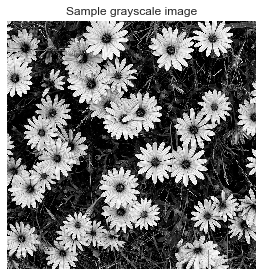

In [23]:
show_image(flower, title="Sample grayscale image")
plt.tight_layout()
plt.savefig("../sample_grayscale.jpg", dpi=300)

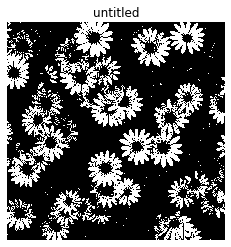

In [76]:
show_image(threshold(flower))

In [47]:
from keras.datasets import fashion_mnist

In [68]:
(_, _), (x, y) = fashion_mnist.load_data()

In [65]:
fashion_k = np.ndarray(shape=(5, 28, 28), dtype='float32')
fashion_t = np.ndarray(shape=(5, 28, 28), dtype='float32')

In [69]:
for i in range(5):
    fashion_k[i] = get_mask(minmax(x[1000+i].astype('float32')))
    fashion_t[i] = threshold(minmax(x[1000+i]))

In [70]:
from evaluation_helpers import plot_range

In [76]:
import matplotlib.pyplot as plt

In [81]:
def plot_range(imgs, RS=0):
    fig = plt.figure(figsize=(15, 15))
    for i in range(0, 5):
        ax = fig.add_subplot(1, 5, i+1)
        show_image(imgs[i+RS], '')
        ax.axis('off')

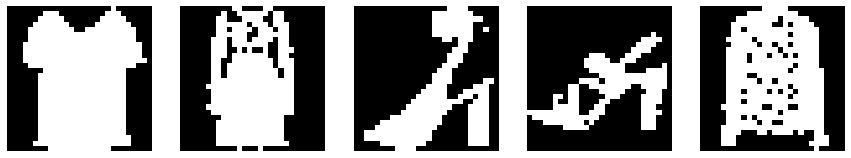

In [82]:
plot_range(fashion_k)

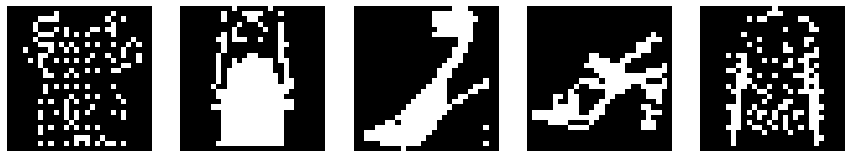

In [83]:
plot_range(fashion_t)

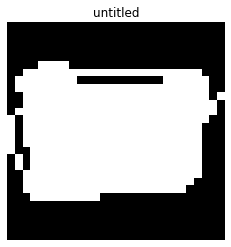

In [53]:
show_image(get_mask(x[56].astype(np.float32)))

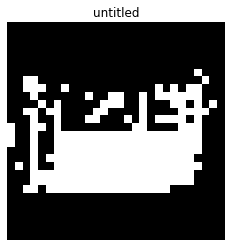

In [50]:
show_image(threshold(x[56]))

## UMAP evaluation

In [ ]:
from dataset_helpers import efficient_shuffle

In [ ]:
efficient_shuffle(x_combined, y_combined, random_state=2211)

In [75]:
baseline_umap = umap_fn(x_combined[-10000:].reshape((10000, 192*192*3)), )

UMAP dimensionality reduction started at 10:51:44


/Users/Leonore/Documents/Workspace/venv/ml/lib/python3.6/site-packages/numba/typed_passes.py:271: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../venv/ml/lib/python3.6/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


UMAP took 1:05:33.653135 to finish


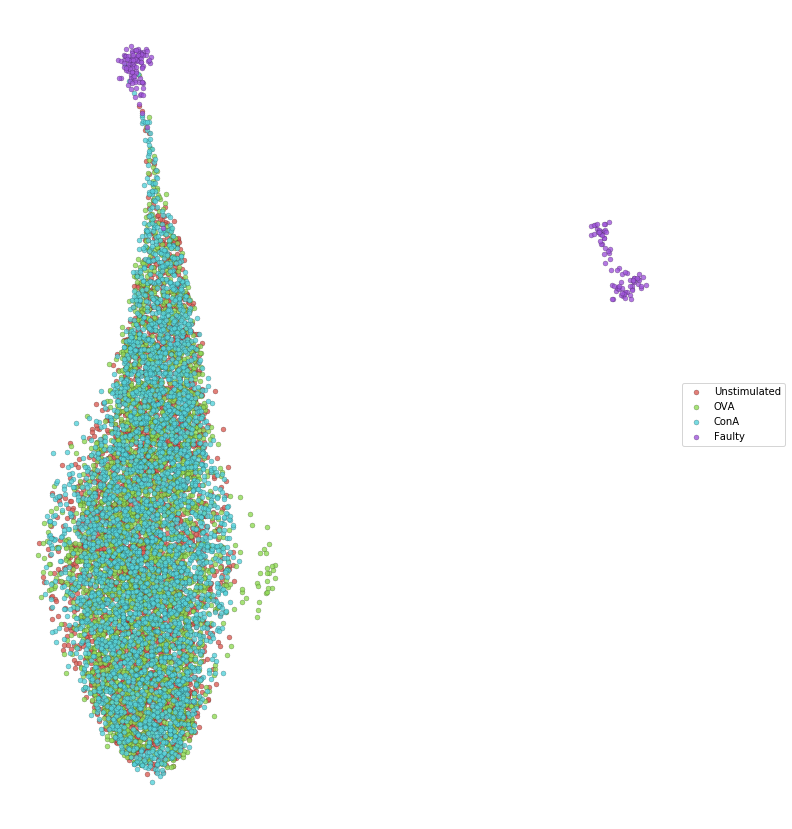

In [77]:
plot_clusters(baseline_umap, y_combined[-10000:])